# Mixture of Gaussians

In this note, we will solve the mixture of Gaussians

This block contains some $\LaTeX$ macros.
$\newcommand{\E}{\mathbb{E}}$
$\renewcommand{\Re}{\mathbb{R}}$
$\newcommand{\oft}[1]{{^{(#1)}}}$
$\newcommand{\oftt}[2]{{^{(#1)#2}}}$

In [9]:
import util
from util import *
import numpy as np
import models
import mompy as mp
import cvxopt

np.set_printoptions(precision=3, suppress=True)
from IPython.display import display, Markdown, Math
from operator import mul
import sympy as sp

sp.init_printing()

## Noiseless Example

Let's construct a toy example for the rest of this document.

Let $\xi_1, ..., \xi_K \in \Re^D$ be the set of means. Let $c_1, ..., c_K \in \Re^D$ be the set of diagonal covariances.

In [14]:
k = 2
d = 2
degobs = 4
degmm = 3

sc.random.seed(101)
gm = models.GaussianMixtureModel.generate('', k, d, means='hypercube', cov='spherical')

monos = gm.polymom_monos(degmm)
constraints = gm.polymom_all_constraints(degobs)
xis = gm.sym_means
covs = gm.sym_covs
sym_all = xis + covs
print 'The polynomial constraints are as follows'
display(constraints)

The polynomial constraints are as follows


With this machinery, we can compute the moment polynomials required for the moment method magic!

In [15]:
MM = mp.MomentMatrix(degmm, sym_all, morder='grevlex', monos=monos)
display(MM.row_monos)

In [16]:
cin = mp.solvers.get_cvxopt_inputs(MM, constraints)
solsdp = cvxopt.solvers.sdp(cin['c'], Gs=cin['G'], hs=cin['h'], A=cin['A'], b=cin['b'])


     pcost       dcost       gap    pres   dres   k/t
 0:  4.2555e+00  4.2555e+00  6e+01  8e+00  1e+00  1e+00
 1:  5.2838e+00  5.7720e+00  5e+00  1e+00  2e-01  6e-01
 2:  6.8541e+00  7.5266e+00  1e+01  1e+00  2e-01  8e-01
 3:  6.8273e+00  6.9310e+00  1e+00  2e-01  3e-02  1e-01
 4:  6.9455e+00  7.0106e+00  8e-01  1e-01  2e-02  8e-02
 5:  6.9954e+00  7.0057e+00  1e-01  2e-02  3e-03  1e-02
 6:  7.0187e+00  7.0258e+00  1e-01  1e-02  2e-03  9e-03
 7:  7.0251e+00  7.0267e+00  2e-02  3e-03  4e-04  2e-03
 8:  7.0279e+00  7.0286e+00  1e-02  1e-03  2e-04  9e-04
 9:  7.0288e+00  7.0290e+00  3e-03  3e-04  4e-05  2e-04
10:  7.0291e+00  7.0292e+00  1e-03  1e-04  2e-05  1e-04
11:  7.0292e+00  7.0292e+00  4e-04  3e-05  5e-06  2e-05
12:  7.0292e+00  7.0292e+00  1e-04  9e-06  1e-06  7e-06
13:  7.0292e+00  7.0292e+00  2e-05  2e-06  4e-07  2e-06
14:  7.0292e+00  7.0292e+00  5e-06  5e-07  7e-08  3e-07
15:  7.0292e+00  7.0292e+00  1e-06  1e-07  1e-08  7e-08
Optimal solution found.


In [18]:
sol_lasserre = mp.extractors.extract_solutions_lasserre(MM, solsdp['x'], Kmax = k)
sol_dreesen = mp.extractors.extract_solutions_dreesen(MM, solsdp['x'], Kmax = k)
trueparams = {}

for i in xrange(d):
    trueparams[xis[i]] = []
    trueparams[covs[i]] = []
    for j in xrange(k):
        trueparams[xis[i]].append(gm.means[i,j])
        trueparams[covs[i]].append(gm.sigmas[j,i,i])
print 'the true parameters'
display(trueparams)
print 'recovered parameters (Lasserre)'
display(sol_lasserre)
print 'recovered parameters (Dreesen)'
display(sol_dreesen)

lost 0.0000024
the next biggest eigenvalue we are losing is 0.000002
the true parameters


recovered parameters (Lasserre)


recovered parameters (Dreesen)


{xi2: [array([ 0.428,  0.207])],
 c1: [array([ 0.874,  0.859])],
 c2: [array([ 0.874,  0.859])],
 xi1: [array([ 0.572,  0.793])]}

## Now take samples!


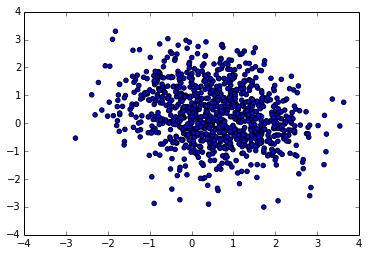

In [27]:
num_samples = 1000
X = gm.sample(num_samples)
import matplotlib.pyplot as plt
%matplotlib inline

import numpy.linalg

# plot after a random orthogonal projection
randdir,__,__ = np.linalg.svd(np.random.randn(d,2))
Y = X.dot(randdir[:,0:2])
plt.scatter(X[:,0], X[:,1]);

constraints_noisy = gm.polymom_all_constraints_samples(degobs, X)
display(constraints_noisy)

In [20]:
cin = mp.solvers.get_cvxopt_inputs(MM, constraints_noisy)
solsdp_noisy = cvxopt.solvers.sdp(cin['c'], Gs=cin['G'], hs=cin['h'], A=cin['A'], b=cin['b'])


     pcost       dcost       gap    pres   dres   k/t
 0:  4.3241e+00  4.3241e+00  6e+01  8e+00  1e+00  1e+00
 1:  5.4196e+00  5.9201e+00  5e+00  1e+00  2e-01  7e-01
 2:  6.8902e+00  7.5423e+00  9e+00  1e+00  2e-01  8e-01
 3:  6.8996e+00  7.0088e+00  1e+00  2e-01  3e-02  1e-01
 4:  7.0531e+00  7.1177e+00  9e-01  1e-01  2e-02  8e-02
 5:  7.1203e+00  7.1296e+00  1e-01  2e-02  3e-03  1e-02
 6:  7.1513e+00  7.1594e+00  1e-01  1e-02  2e-03  1e-02
 7:  7.1729e+00  7.1750e+00  4e-02  4e-03  6e-04  3e-03
 8:  7.1795e+00  7.1805e+00  2e-02  2e-03  3e-04  1e-03
 9:  7.1831e+00  7.1833e+00  5e-03  5e-04  8e-05  3e-04
10:  7.1844e+00  7.1845e+00  1e-03  1e-04  2e-05  8e-05
11:  7.1848e+00  7.1848e+00  2e-04  2e-05  3e-06  1e-05
12:  7.1848e+00  7.1848e+00  5e-05  5e-06  8e-07  3e-06
13:  7.1848e+00  7.1848e+00  6e-06  6e-07  1e-07  4e-07
14:  7.1848e+00  7.1848e+00  9e-07  9e-08  1e-08  6e-08
Optimal solution found.


In [21]:
sol_lasserre_noisy = mp.extractors.extract_solutions_lasserre(MM, solsdp_noisy['x'], Kmax = k)
sol_dreesen_noisy = mp.extractors.extract_solutions_dreesen_proto(MM, solsdp_noisy['x'], Kmax = k)

print 'the true parameters'
display(trueparams)
print 'recovered parameters (Lasserre)'
display(sol_lasserre_noisy)
print 'recovered parameters (Dreesen)'
display(sol_dreesen_noisy)

the next biggest eigenvalue we are losing is 0.153149
the true parameters


recovered parameters (Lasserre)


recovered parameters (Dreesen)


## EM Algorithm

In [22]:
from algos import GaussianMixturesEM
reload(GaussianMixturesEM)
algo = GaussianMixturesEM.GaussianMixtureEM( k, d )
X.shape
lhood, Z, O_ = algo.run( X, None )

Iteration 0, lhood = -18192.844799
Iteration 1, lhood = -11012.854974
Iteration 2, lhood = -11032.759876
Iteration 3, lhood = -11090.797527
Iteration 4, lhood = -11157.014391
Iteration 5, lhood = -11222.441210
Iteration 6, lhood = -11293.032853
Iteration 7, lhood = -11378.668552
Iteration 8, lhood = -11490.014140
Iteration 9, lhood = -11639.201377
Iteration 10, lhood = -11840.641868
Iteration 11, lhood = -12108.935419
Iteration 12, lhood = -12447.130646
Iteration 13, lhood = -12816.209432
Iteration 14, lhood = -13111.247884
Iteration 15, lhood = -13220.288142
Iteration 16, lhood = -13131.425178
Iteration 17, lhood = -13024.645968
Iteration 18, lhood = -13009.873861
Converged with lhood=-13009.873861 in 18 steps.


In [23]:
O_, gm.weights

((array([[ 0.649,  0.   ],
         [ 0.334,  0.   ]]), array([ 1.493,  0.   ]), array([ 1.,  0.])),
 array([ 0.639,  0.361]))

In [24]:
gm.sigmas

array([[[ 0.843,  0.   ],
        [ 0.   ,  0.843]],

       [[ 0.917,  0.   ],
        [ 0.   ,  0.917]]])

In [25]:
k, d, M, S, w = gm.k, gm.d, gm.means, gm.sigmas, gm.weights
import algos.GaussianMixturesSpectral as gms
M_ = gms.find_means(X, k)
print "M_", M_.T


M_ [[-0.008  0.744]
 [ 0.94  -0.031]]
